## Setup

In [1]:
from environment import (
    CollisionChecker, 
    construct_benchmark_environments, 
    retrieve_path_positions, 
    calculate_path_length, 
    plot_performance_data, 
    calculate_path_length, 
    clear_graph_attributes,
    analyze_optimal_k
)
from planners.IPBasicPRM import BasicPRM
from optimize_path import OptimizeFlyby
from planners.IPPerfMonitor import IPPerfMonitor
import pprint
import networkx as nx
import random
import time
import matplotlib.pyplot as plt

## Load Environments

In [2]:
env_dict = construct_benchmark_environments()

## Create Planner and Collision Checker for each environment

In [3]:
for name, item in env_dict.items():
    cc = CollisionChecker(item["env"])
    planner = BasicPRM(cc)
    # Inject Graph
    G = nx.Graph()

    node_names = []

    for i, coord in enumerate(item["smooth_path"]):
        # Determine the name based on position in the list
        if i == 0:
            n = "start"
        elif i == len(item["smooth_path"]) - 1:
            n = "goal"
        else:
            n = f"{i}" # Naming middle nodes generically
        
        node_names.append(n)
        
        # Add node with the 'pos' attribute
        G.add_node(n, pos=coord)

    # Add edges connecting each node to the next
    for i in range(len(node_names) - 1):
        current_node = node_names[i]
        next_node = node_names[i+1]
        G.add_edge(current_node, next_node)

    planner.graph = G
    
    env_dict[name]["solution_node_names"] = node_names
    env_dict[name]["planner"] = planner
    del env_dict[name]["smooth_path"]

pprint.pprint(env_dict)

{'1': {'env': {'obs_1': <POLYGON ((5 0, 8 0, 8 9, 5 9, 5 0))>,
               'obs_2': <POLYGON ((11 0, 16 0, 16 6, 11 6, 11 0))>,
               'obs_3': <POLYGON ((10 11, 10.006 10.804, 10.026 10.608, 10.058 10.415, 10.102 10.224...>},
       'planner': <planners.IPBasicPRM.BasicPRM object at 0x7a370bbfb170>,
       'solution_node_names': ['start', '1', '2', '3', '4', 'goal']},
 '2': {'env': {'obs_1': <POLYGON ((0 2, 15 2, 15.5 1.5, 16 2, 16 3, 0 3, 0 2))>,
               'obs_2': <POLYGON ((10 5, 20 5, 20 6, 10 6, 10 5))>,
               'obs_3': <POLYGON ((0 8, 16 8, 16 10, 0 10, 0 8))>,
               'obs_4': <POLYGON ((2 11, 20 11, 20 12, 2 12, 2 11))>,
               'obs_5': <POLYGON ((0 14, 5 14, 5 15, 0 15, 0 14))>,
               'obs_6': <POLYGON ((4 17, 20 17, 20 18, 4 18, 4 17))>,
               'obs_7': <POLYGON ((17.2 0, 20 0, 20 5, 17.2 5, 17.2 0))>},
       'planner': <planners.IPBasicPRM.BasicPRM object at 0x7a370c1cf200>,
       'solution_node_names': ['start',
   

## Show the Environments

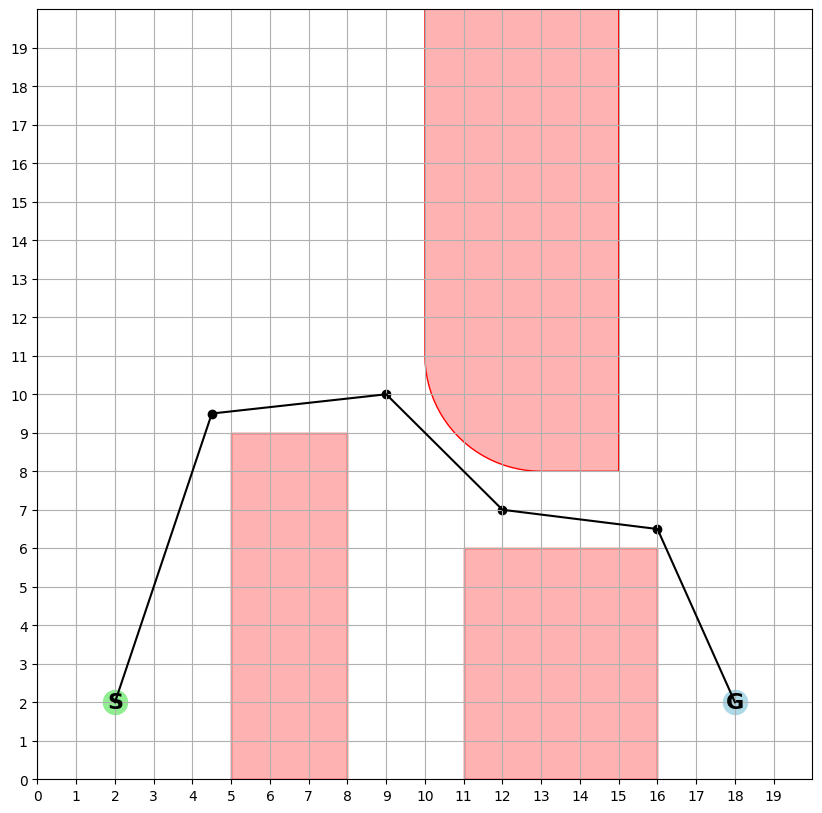

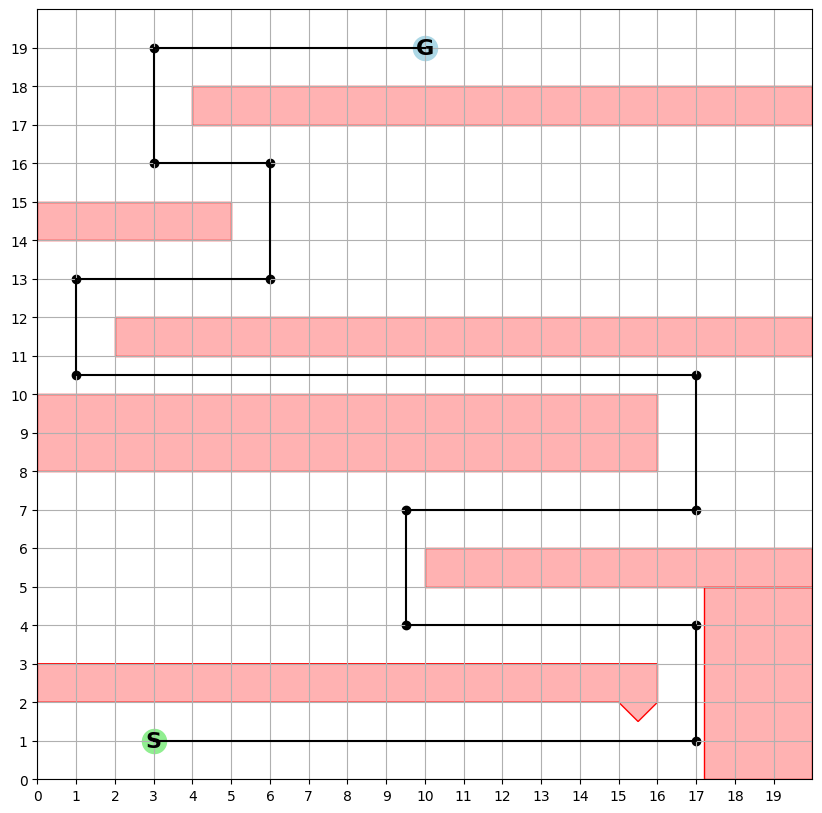

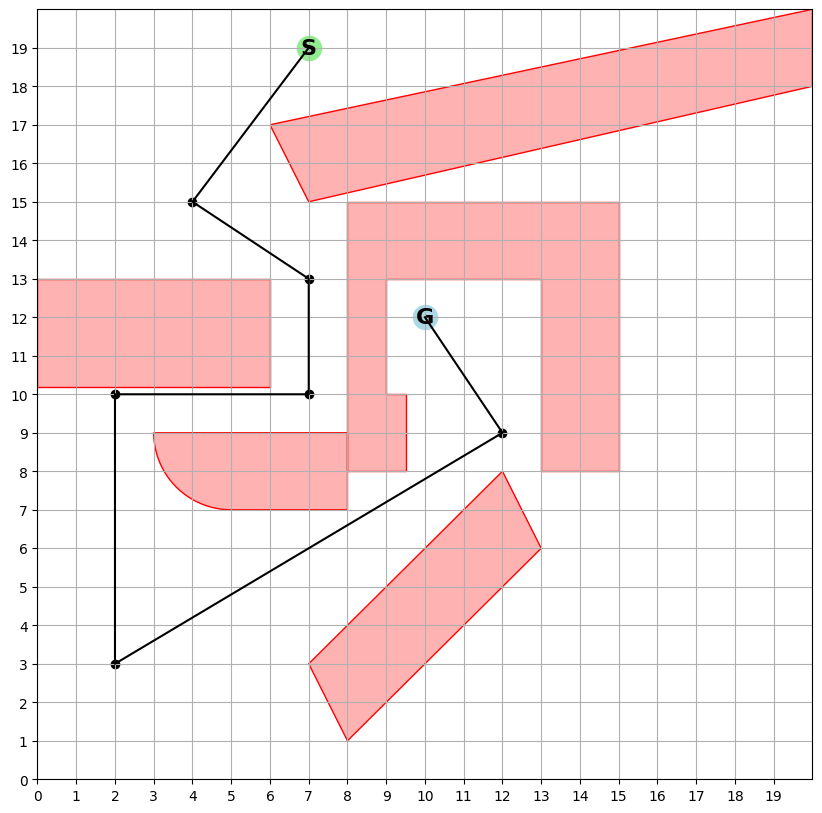

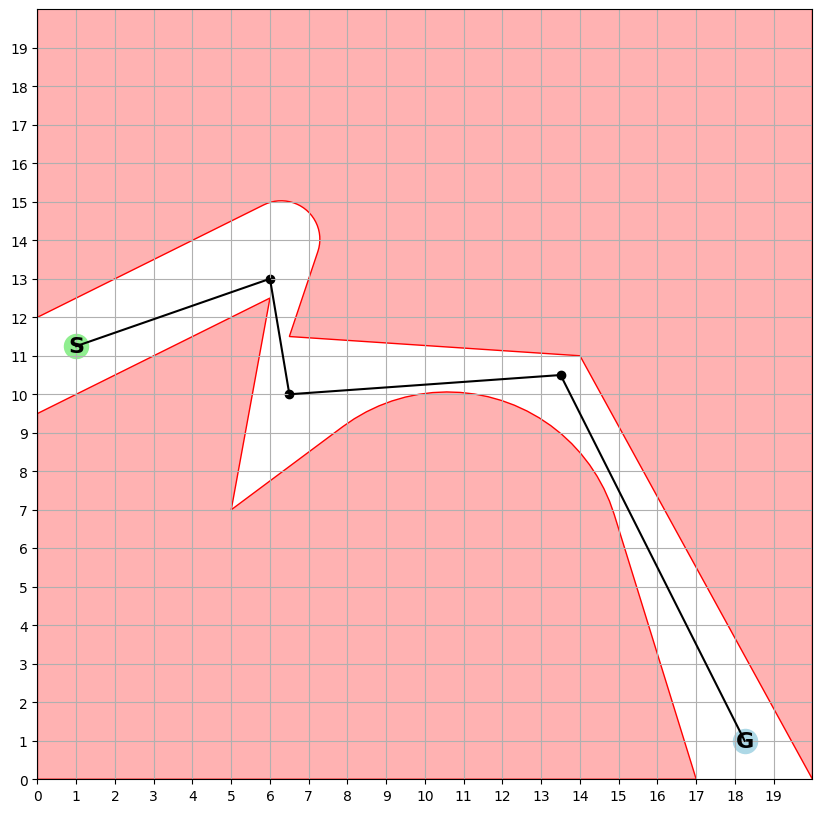

In [4]:
for name, item in env_dict.items():
    ax = item["planner"]._collisionChecker.draw_enviroments()
    item["planner"]._collisionChecker.draw_path(retrieve_path_positions(item['planner'].graph, item['solution_node_names']), ax=ax)


## Round the corners (second model)

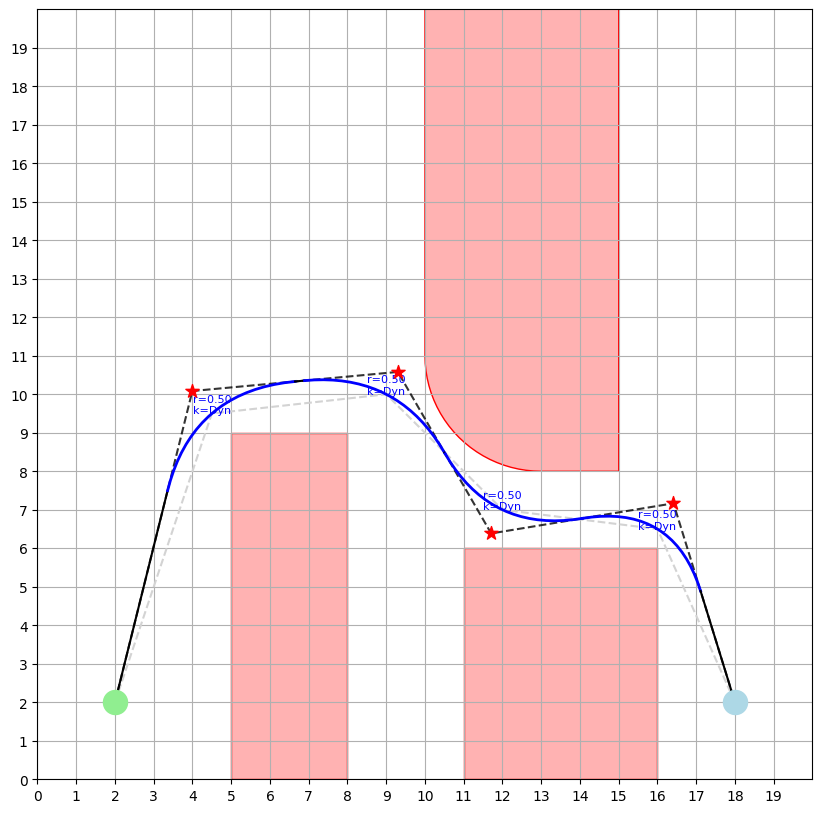

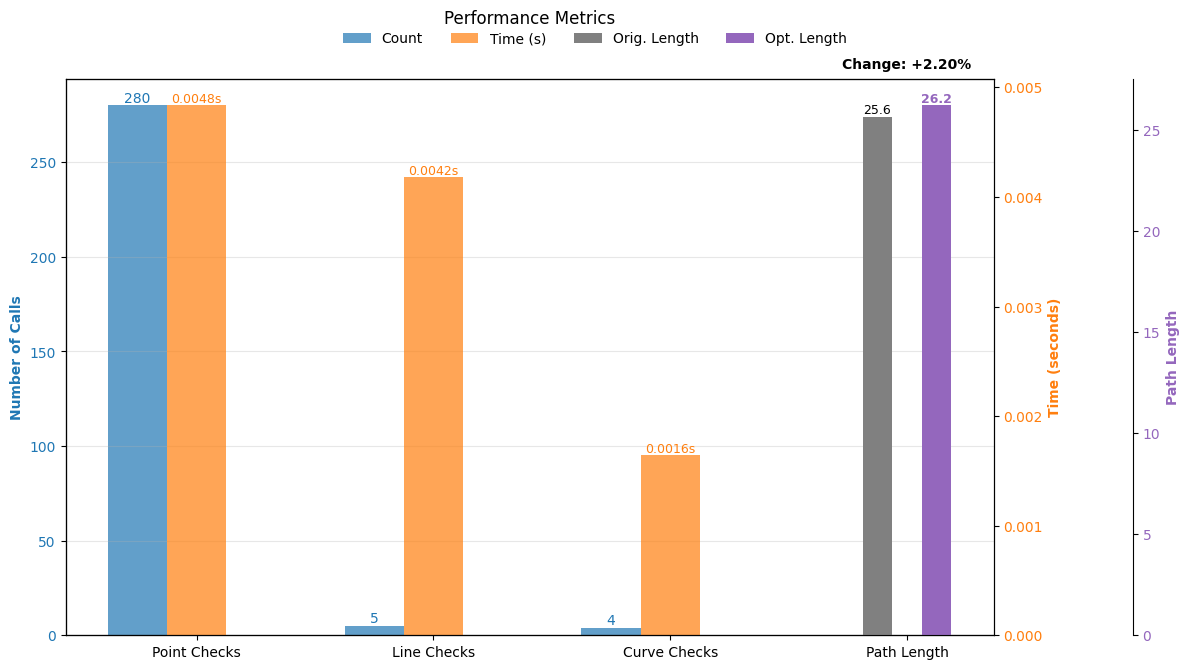

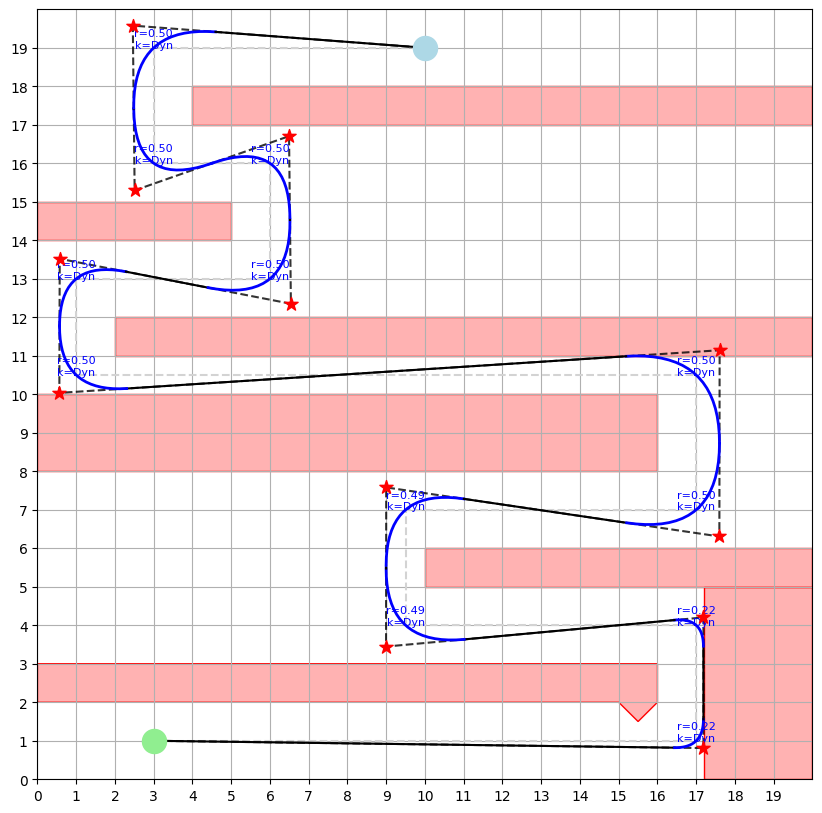

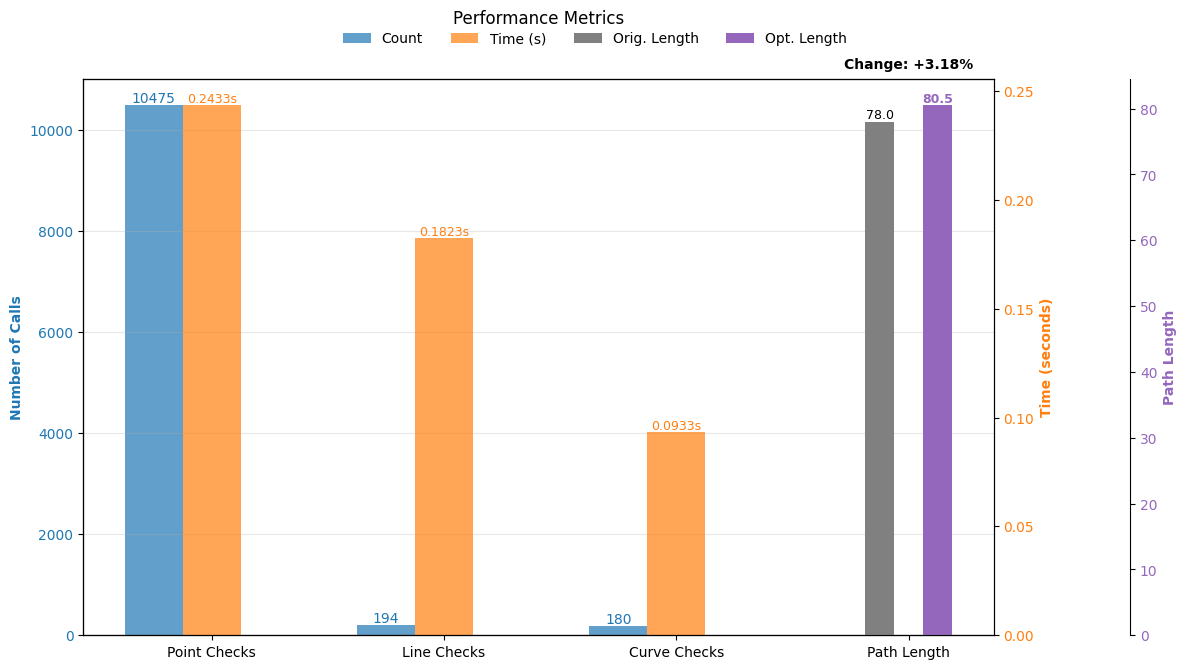

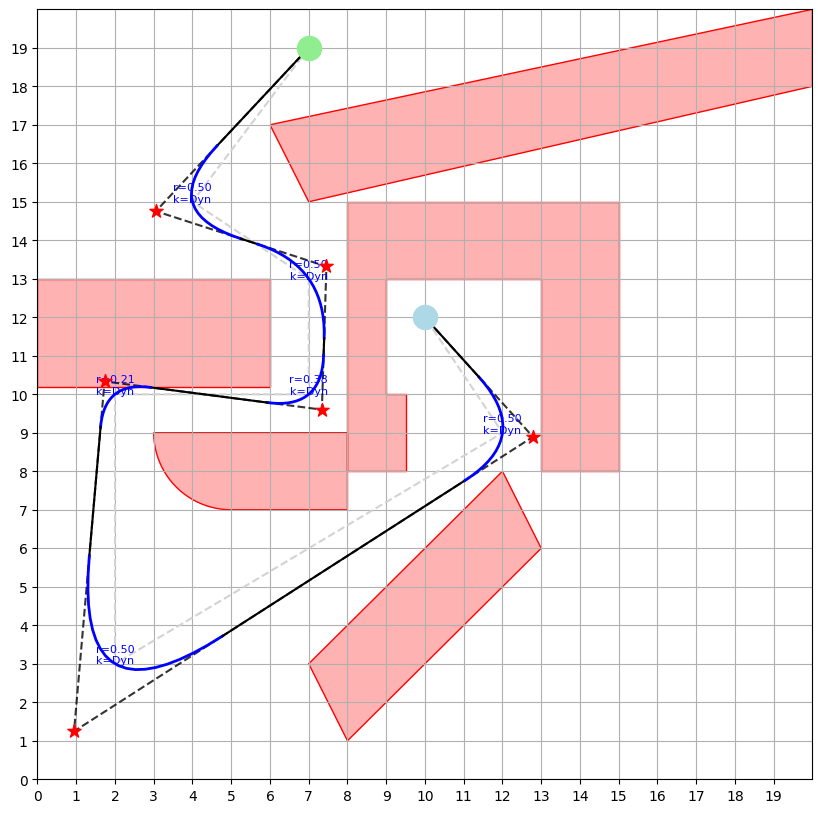

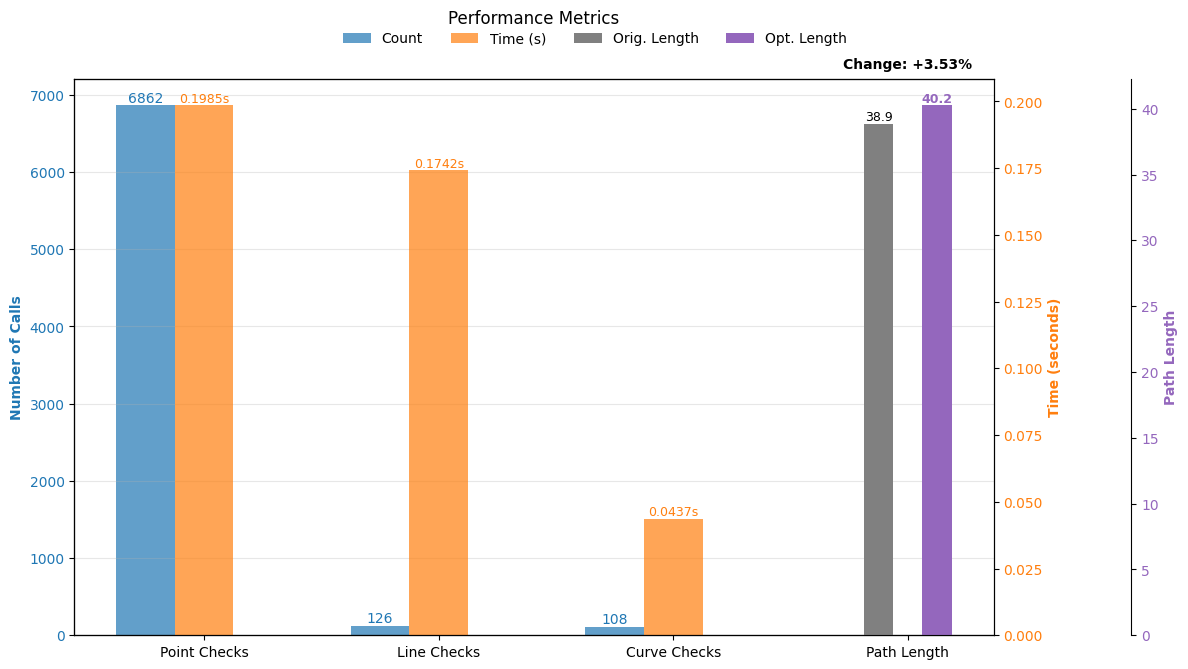

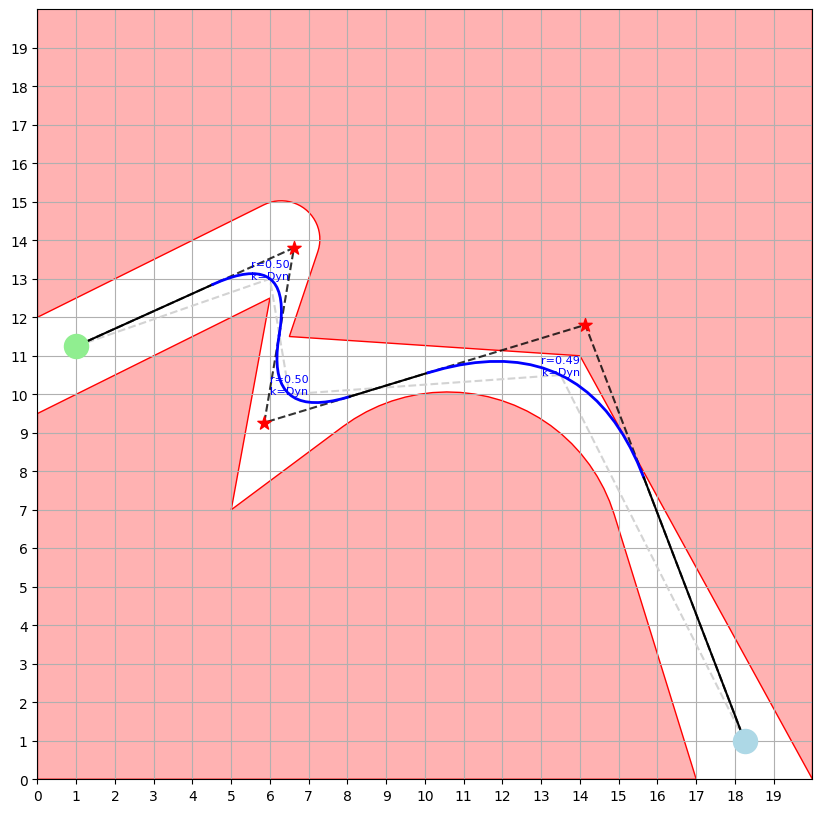

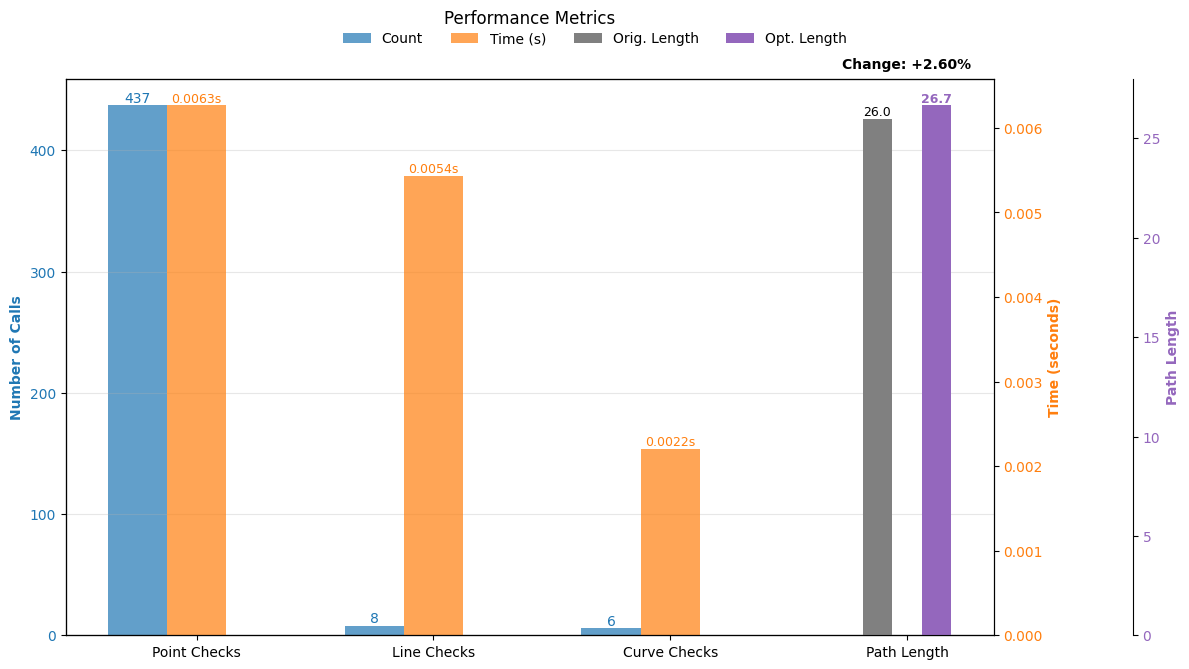

In [5]:
optimizer = OptimizeFlyby()
for name, item in env_dict.items():
    # 1. Setup
    planner = item['planner']
    node_names = item['solution_node_names']
    config = {'r_init': 0.5, 'k': None}

    # Clear previous performance data
    IPPerfMonitor.clearData()

    # Clear old node attributes
    clear_graph_attributes(planner)

    # 2. Run Optimization
    optimized_path = optimizer.optimizePath(node_names, planner, config)

    # 3. Get performance data
    df = IPPerfMonitor.dataFrame()
    

    # Extract number of collisionChecks and corresponding calculation time
    funcs = ['lineInCollision', 'curveInCollision', 'pointInCollision']
    stats = {}
    for f in funcs:
        f_data = df[df['name'] == f]
        if not f_data.empty:
            stats[f] = {'count': len(f_data), 'time': f_data['time'].sum()}
        else:
            stats[f] = {'count': 0, 'time': 0.0}

    # Calculate path lengths
    len_original = calculate_path_length(planner, node_names, use_curves=False)
    len_optimized = calculate_path_length(planner, node_names, use_curves=True)

    # 4. Show the optimized path
    ax = item['planner']._collisionChecker.draw_enviroments()
    ax = item['planner']._collisionChecker.draw_optimized_path(optimized_path, item["planner"], ax)

    # 5. Plot the performance data
    plot_performance_data(stats, len_original, len_optimized)

## k Optimization


Processing Environment 1...
--- Starting K-Sweep for r_init=0.5 ---
--- Result ---
Optimal Global k: 1.10
Minimum Length:   26.3019m


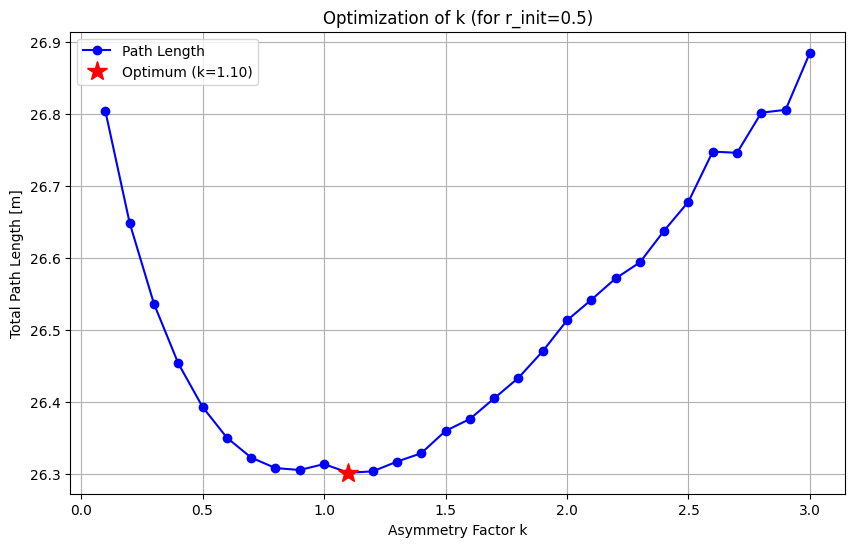

Applying optimal k=1.10 for final visualization...


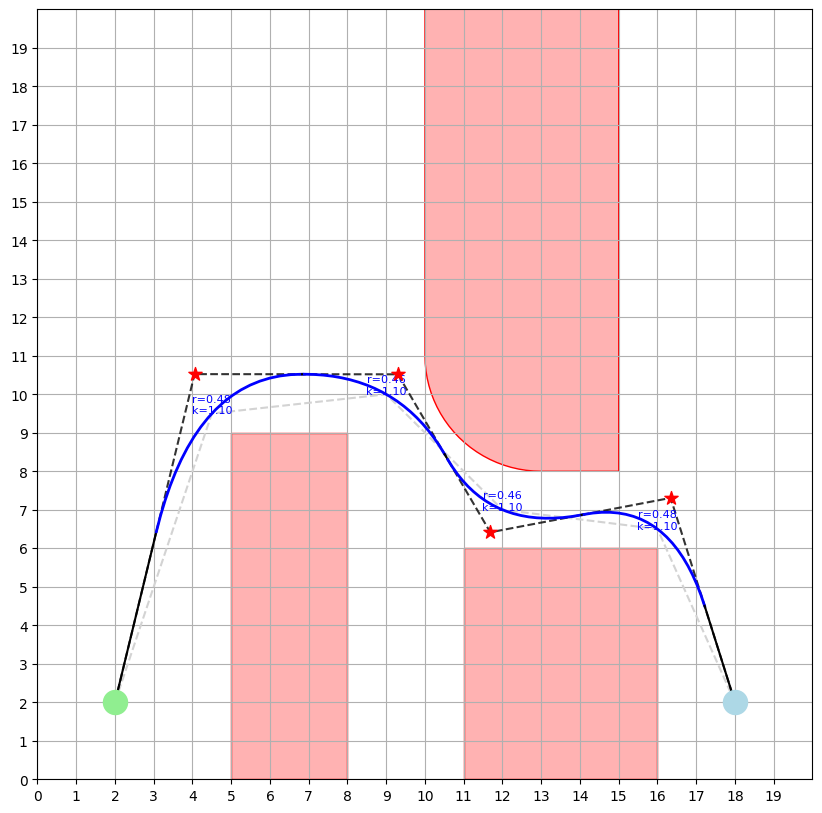

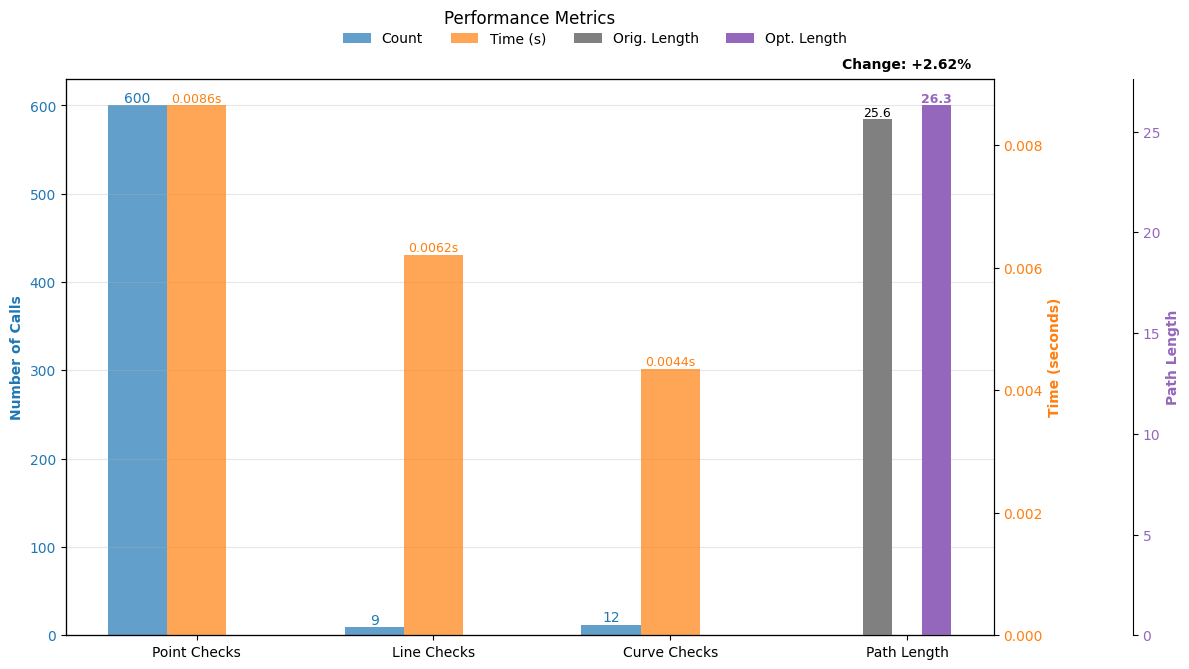


Processing Environment 2...
--- Starting K-Sweep for r_init=0.5 ---
--- Result ---
Optimal Global k: 0.50
Minimum Length:   84.2299m


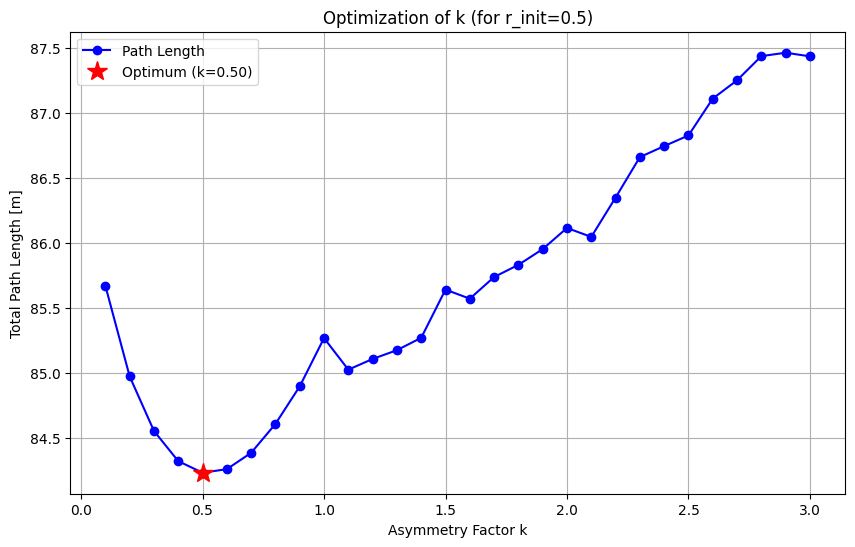

Applying optimal k=0.50 for final visualization...


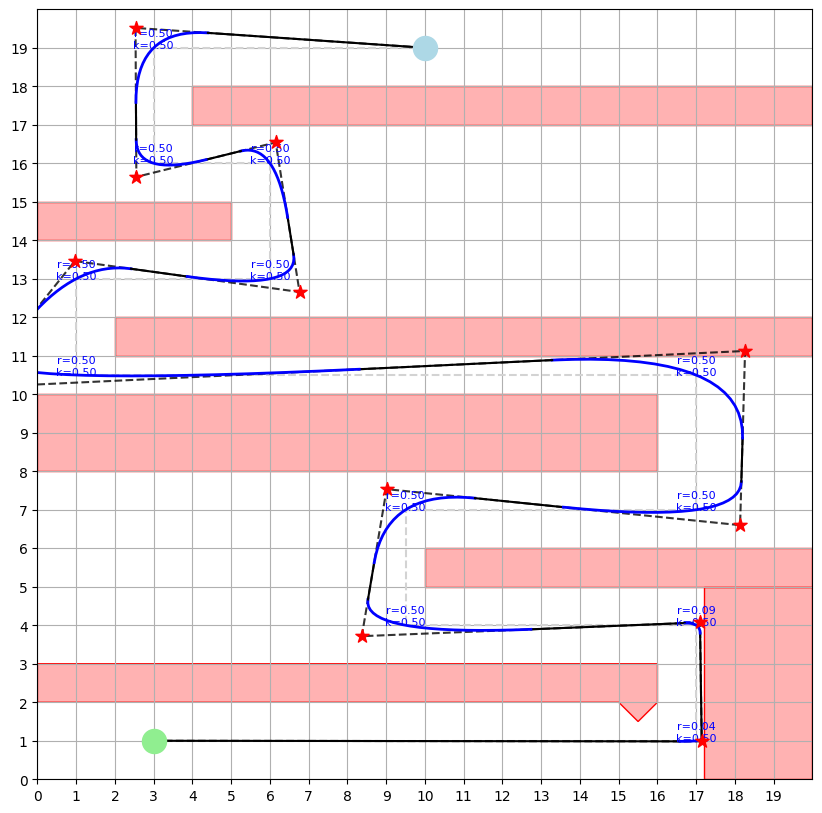

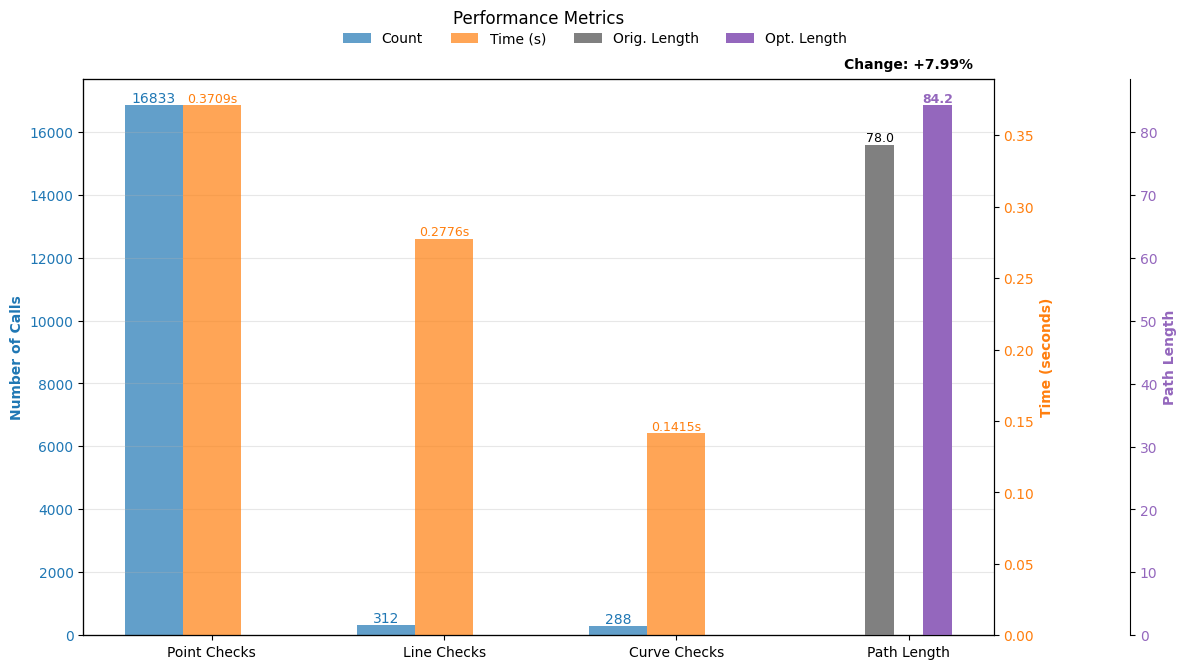


Processing Environment 3...
--- Starting K-Sweep for r_init=0.5 ---
--- Result ---
Optimal Global k: 0.80
Minimum Length:   41.5258m


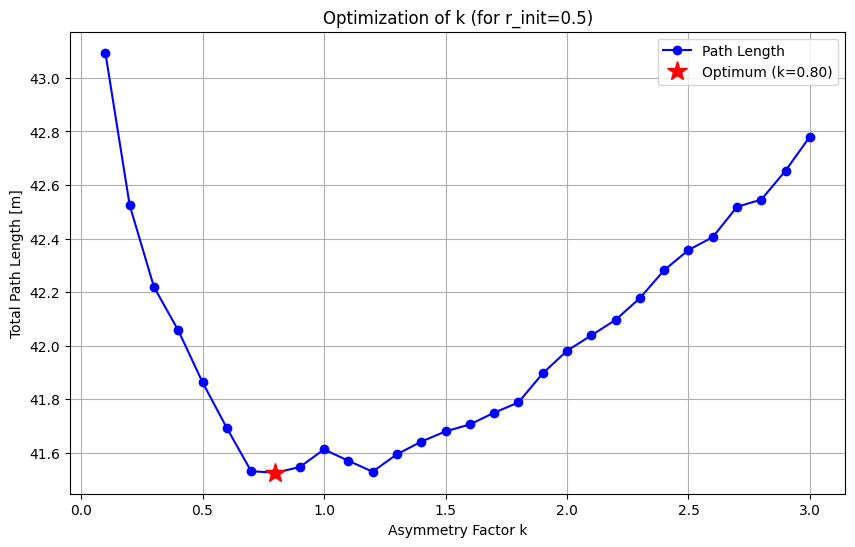

Applying optimal k=0.80 for final visualization...


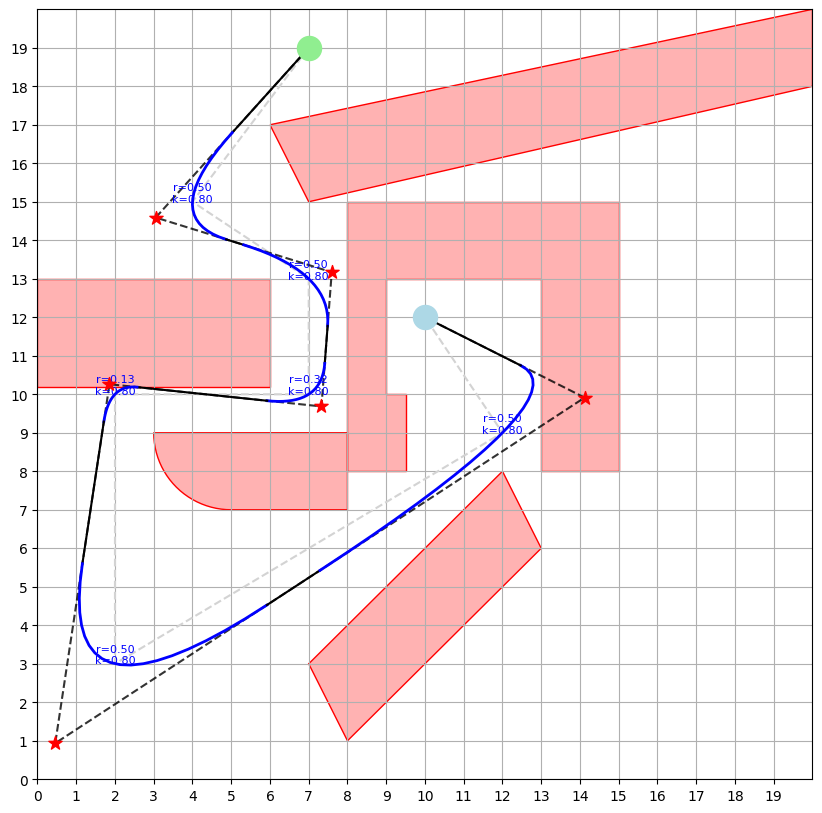

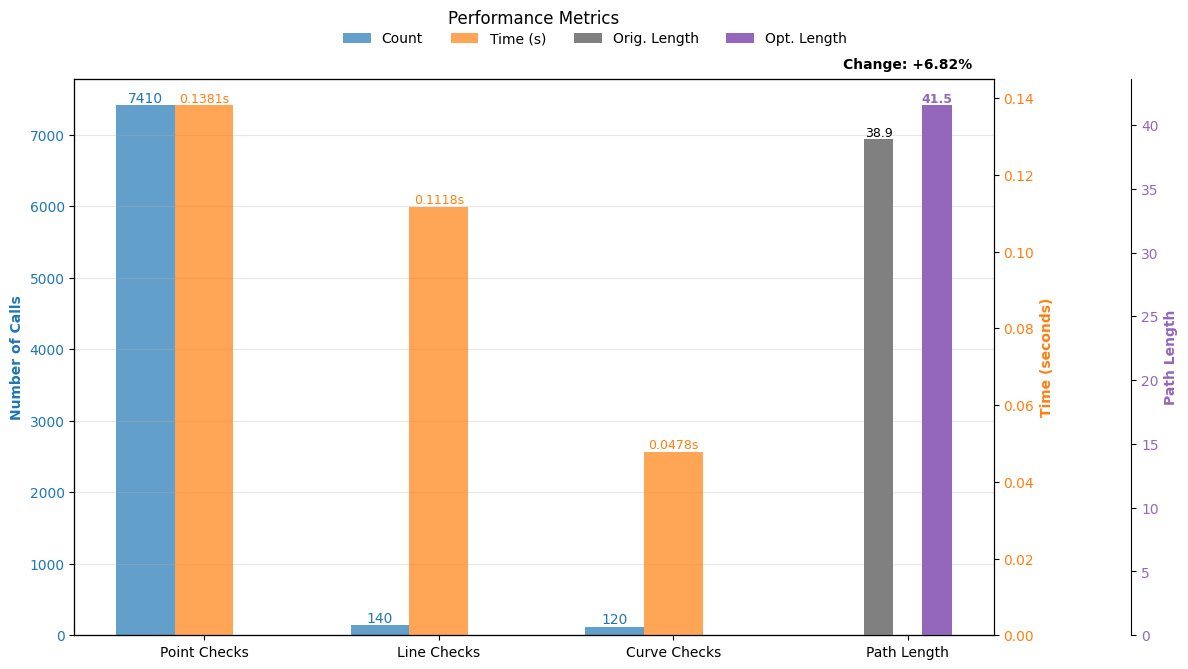


Processing Environment 4...
--- Starting K-Sweep for r_init=0.5 ---
--- Result ---
Optimal Global k: 0.70
Minimum Length:   26.7624m


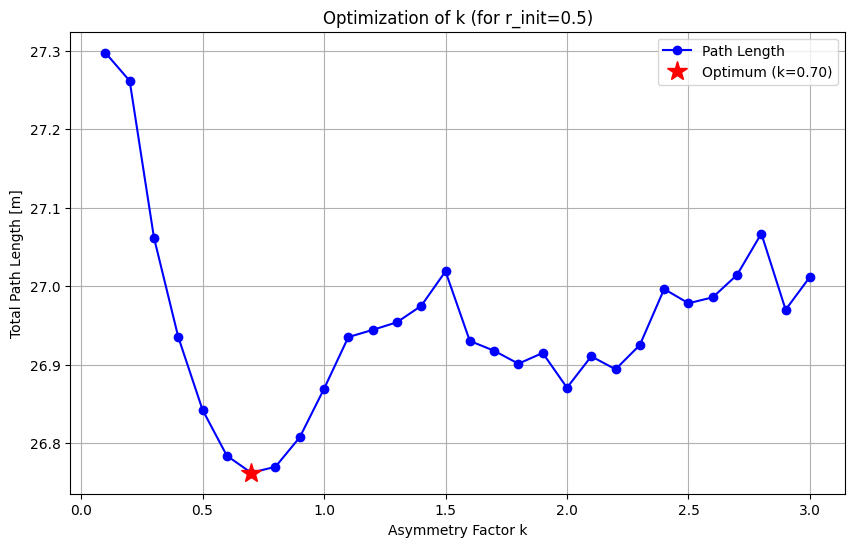

Applying optimal k=0.70 for final visualization...


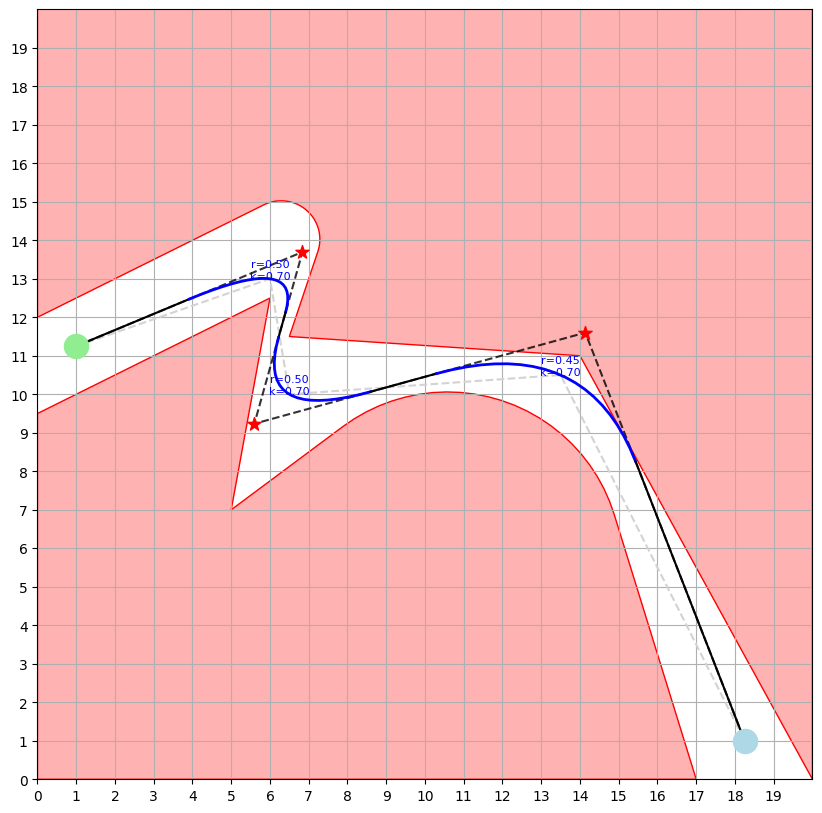

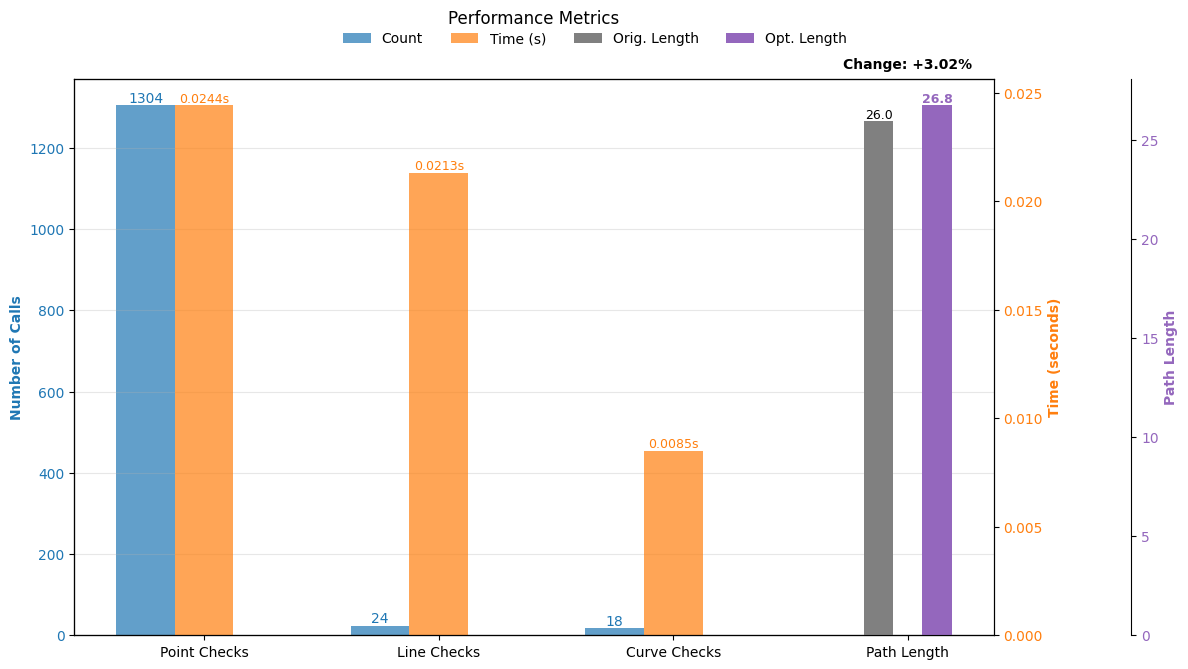

In [6]:
optimizer = OptimizeFlyby()

for name, item in env_dict.items():
    print(f"\nProcessing Environment {name}...")
    
    # 1. Setup
    planner = item['planner']
    node_names = item['solution_node_names']
    IPPerfMonitor.clearData()

    # --- TASK: Determine Optimal K ---
    # This runs the sweep and plots the graph
    best_k = analyze_optimal_k(optimizer, planner, node_names, r_fixed=0.5)

    # 2. Run Final Optimization with Best K
    # Now we apply the best k we found to generate the final path for visualization
    print(f"Applying optimal k={best_k:.2f} for final visualization...")
    
    clear_graph_attributes(planner)
    config = {'r_init': 0.5, 'k': best_k} 

    # Clear previous performance data
    IPPerfMonitor.clearData()

    # Run Optimization
    optimized_path = optimizer.optimizePath(node_names, planner, config)

    # 3. Get performance data
    df = IPPerfMonitor.dataFrame()

    # Extract number of collisionChecks and corresponding calculation time
    funcs = ['lineInCollision', 'curveInCollision', 'pointInCollision']
    stats = {}
    for f in funcs:
        f_data = df[df['name'] == f]
        if not f_data.empty:
            stats[f] = {'count': len(f_data), 'time': f_data['time'].sum()}
        else:
            stats[f] = {'count': 0, 'time': 0.0}
    
    # 4. Calculate path lengths
    len_original = calculate_path_length(planner, node_names, use_curves=False)
    len_optimized = calculate_path_length(planner, node_names, use_curves=True)

    # 5. Visualizations
    # Show the Optimized Path
    ax = item['planner']._collisionChecker.draw_enviroments()
    item['planner']._collisionChecker.draw_optimized_path(optimized_path, item["planner"], ax)
    plt.show()

    # Show the Bar Chart
    # (Be sure to pass the updated stats dictionary here)
    plot_performance_data(stats, len_original, len_optimized)

## Optimize individual k's


Processing Environment 1 (Individual Corner Optimization)
Starting Individual Corner Optimization...
--- Pass 1 ---
--- Pass 2 ---
Converged early.
Optimization Complete.


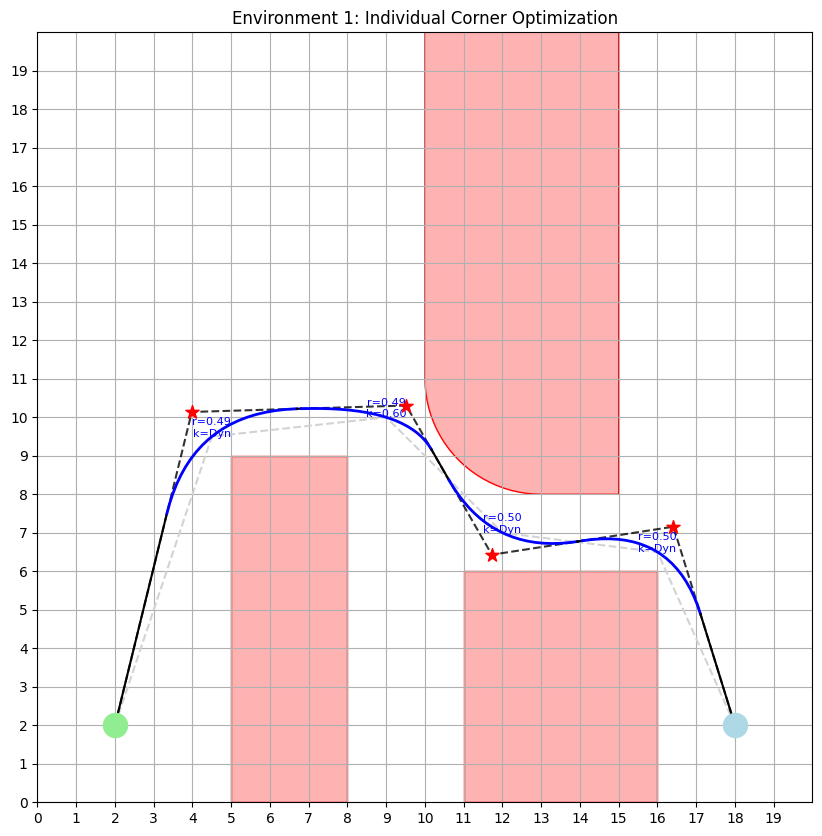

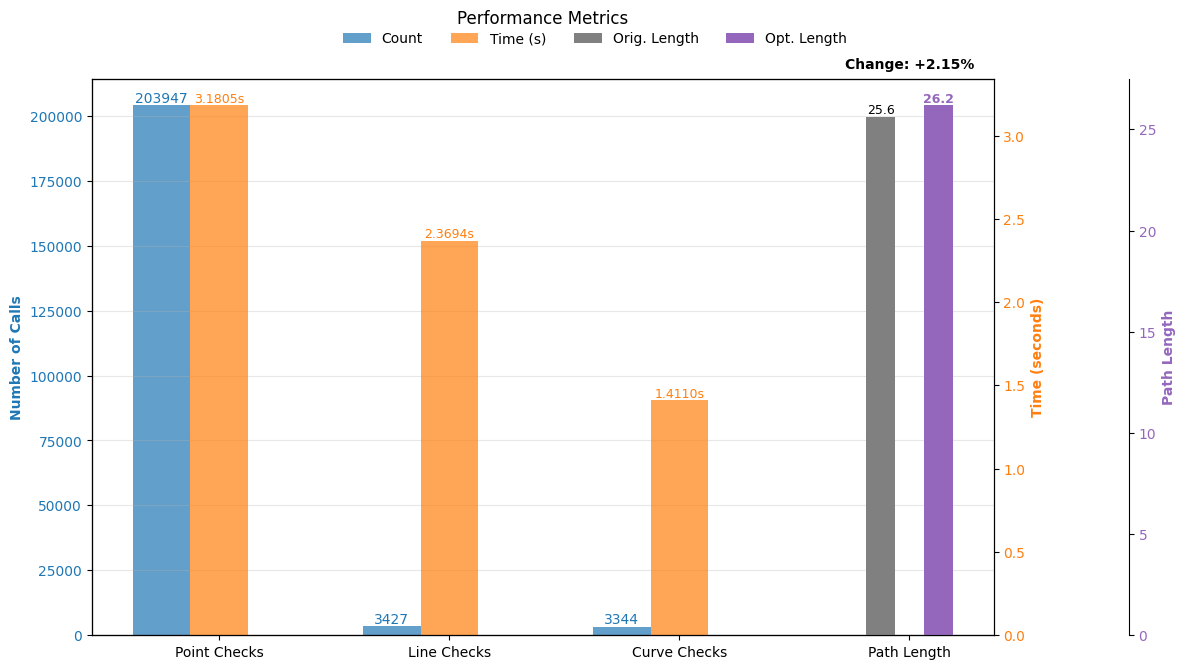


Processing Environment 2 (Individual Corner Optimization)
Starting Individual Corner Optimization...
--- Pass 1 ---
--- Pass 2 ---
Optimization Complete.


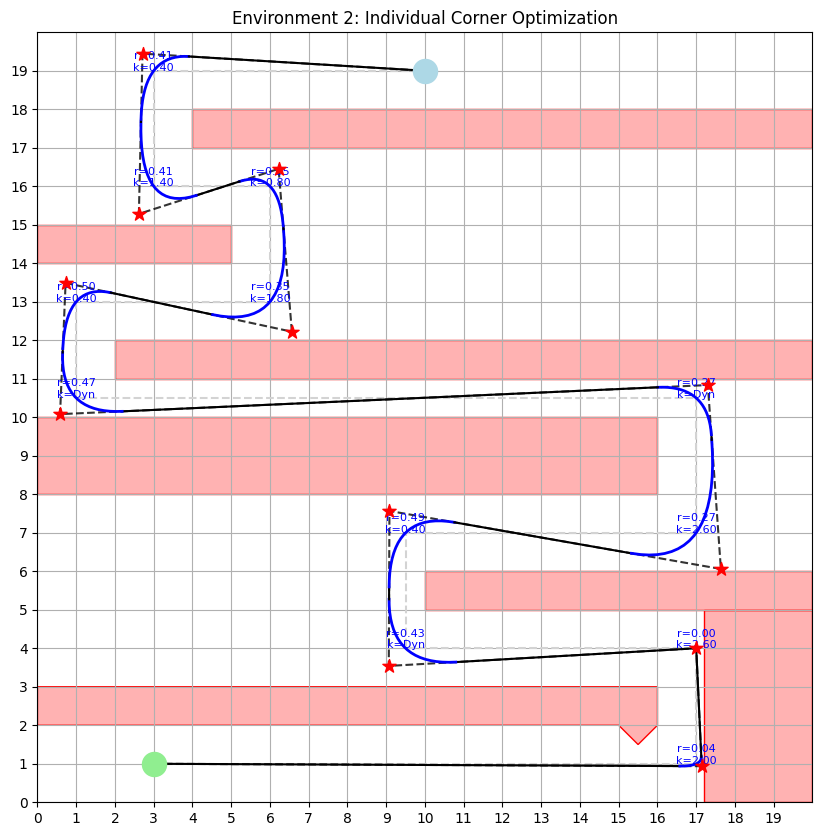

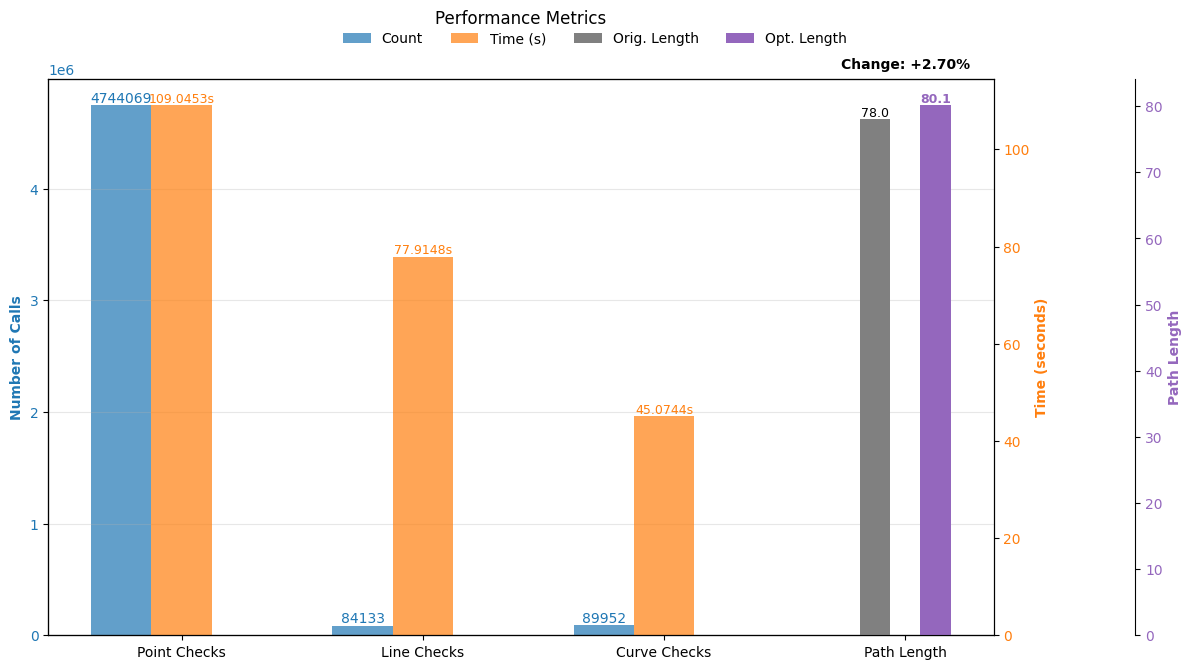


Processing Environment 3 (Individual Corner Optimization)
Starting Individual Corner Optimization...
--- Pass 1 ---
--- Pass 2 ---
Optimization Complete.


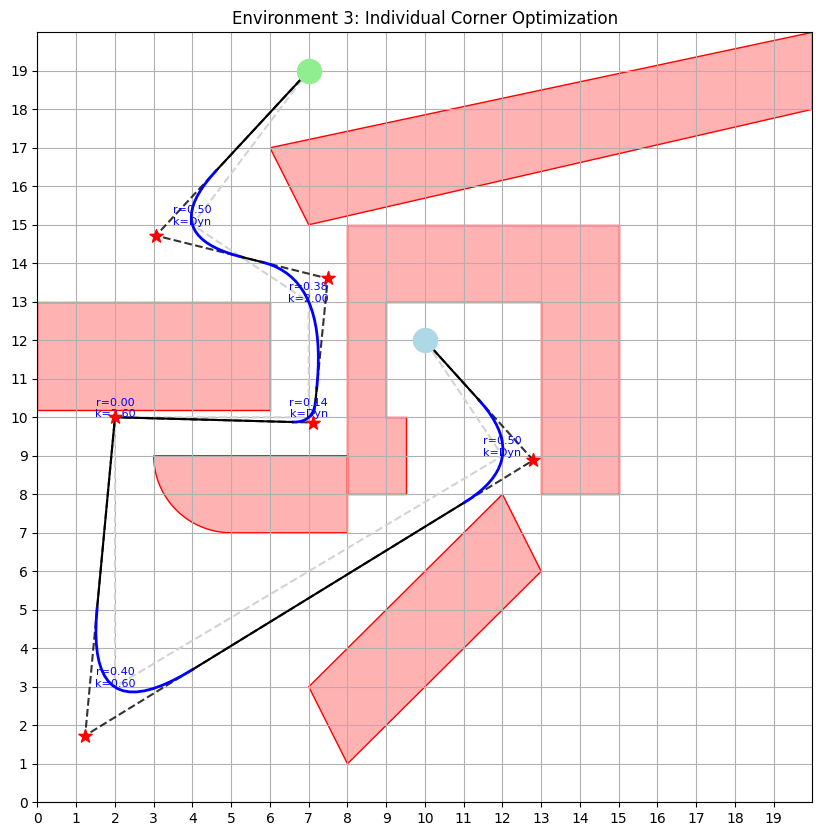

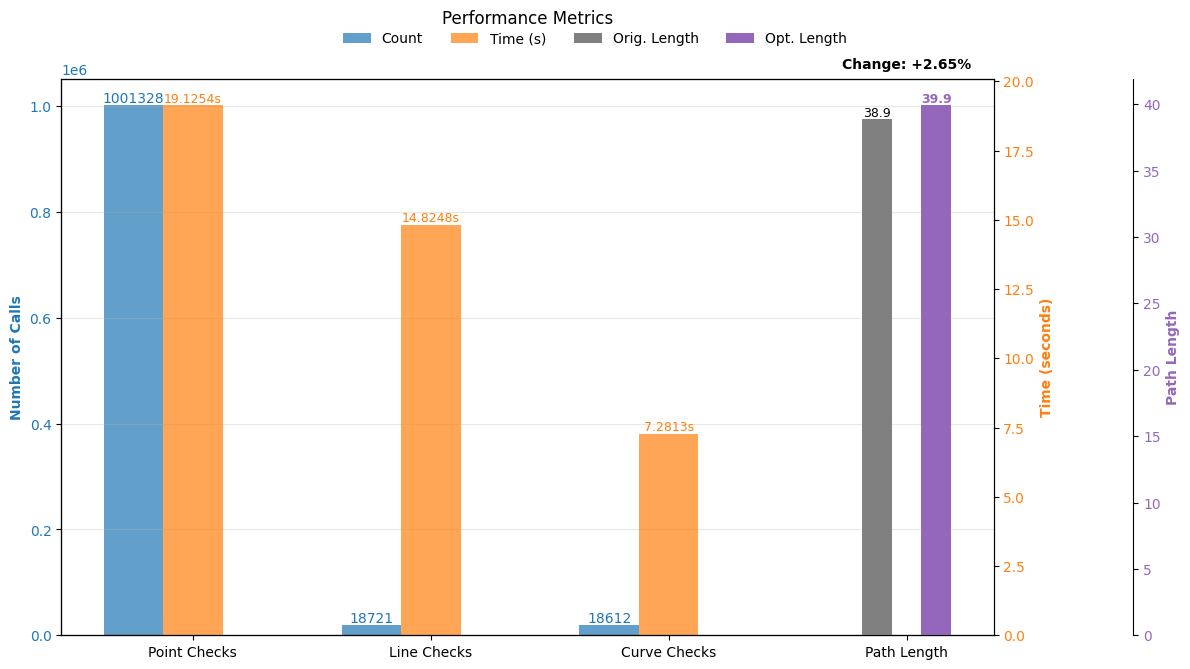


Processing Environment 4 (Individual Corner Optimization)
Starting Individual Corner Optimization...
--- Pass 1 ---
--- Pass 2 ---
Optimization Complete.


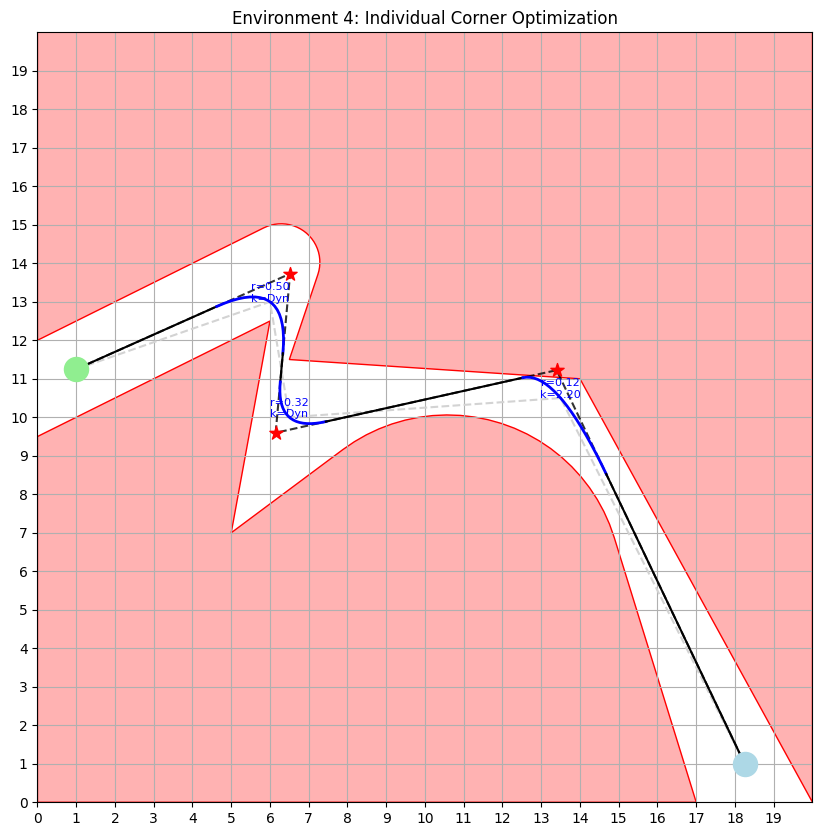

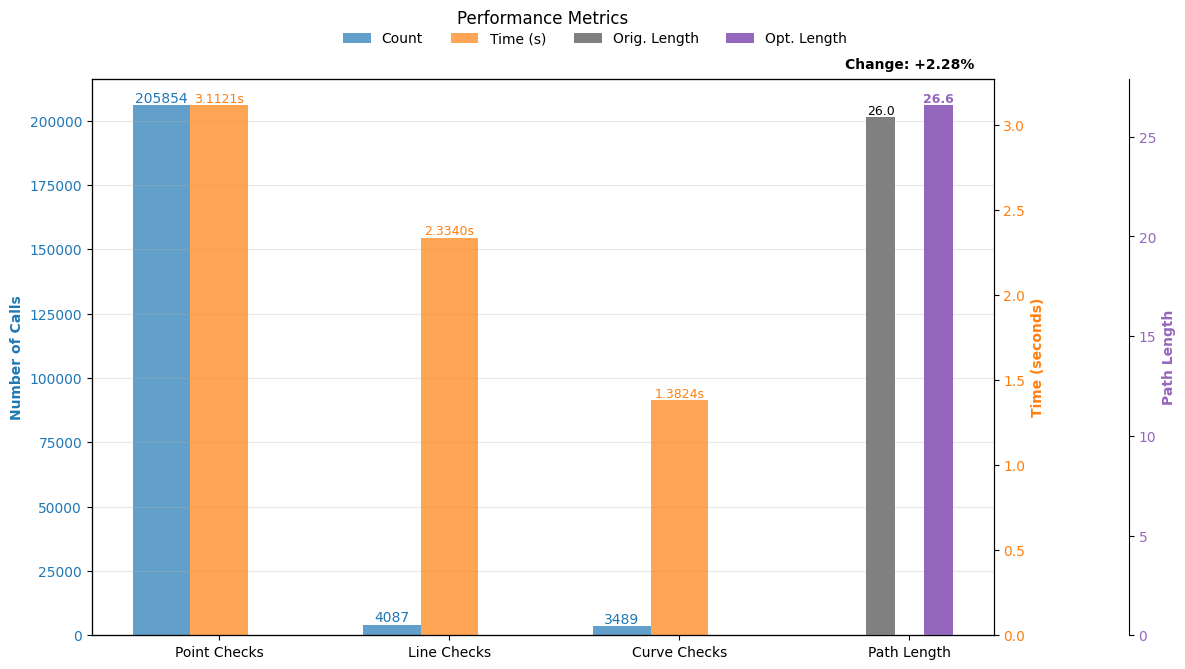

In [7]:
optimizer = OptimizeFlyby()

for name, item in env_dict.items():
    print(f"\n{'='*60}")
    print(f"Processing Environment {name} (Individual Corner Optimization)")
    print(f"{'='*60}")
    
    # 1. Setup
    planner = item['planner']
    node_names = item['solution_node_names']
    
    # 2. Preparation: Clean slate
    clear_graph_attributes(planner)
    IPPerfMonitor.clearData()

    # 3. Run Optimization (Coordinate Descent)
    # This function repeatedly calls optimizePath to test k values for each node individually.
    # It returns the final result with the best configuration found.
    optimized_path = optimizer.optimize_individual_corners(node_names, planner, config={'r_init': 0.5})

    # 4. Get Performance Data
    df = IPPerfMonitor.dataFrame()

    # Extract collision check stats
    funcs = ['lineInCollision', 'curveInCollision', 'pointInCollision']
    stats = {}
    for f in funcs:
        f_data = df[df['name'] == f]
        if not f_data.empty:
            stats[f] = {'count': len(f_data), 'time': f_data['time'].sum()}
        else:
            stats[f] = {'count': 0, 'time': 0.0}
    
    # 5. Calculate Path Lengths
    len_original = calculate_path_length(planner, node_names, use_curves=False)
    len_optimized = calculate_path_length(planner, node_names, use_curves=True)

    # 6. Visualizations
    
    # A. Optimized Path Visualization
    ax = item['planner']._collisionChecker.draw_enviroments()
    
    # Draw the path (this will show specific k values for each node)
    item['planner']._collisionChecker.draw_optimized_path(optimized_path, item["planner"], ax)
    
    plt.title(f"Environment {name}: Individual Corner Optimization")
    plt.show() 

    # B. Performance Metrics Chart
    plot_performance_data(stats, len_original, len_optimized)